In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers, models
from tensorflow import data as tf_data
keras.config.set_image_data_format("channels_first")

2025-07-09 02:05:21.806238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752019521.817831   24944 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752019521.821255   24944 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752019521.830380   24944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752019521.830398   24944 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752019521.830400   24944 computation_placer.cc:177] computation placer alr

In [2]:
from keras import backend as K
print(K.backend())

tensorflow


In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    "/home/pico/code/human_presence_classifier/data/human_dataset/train",
    seed=1337,
    image_size=(96,96),
    batch_size=32,
    label_mode="binary"
)

val_ds = keras.utils.image_dataset_from_directory(
    "/home/pico/code/human_presence_classifier/data/human_dataset/validation",
    seed=1337,
    image_size=(96,96),
    batch_size=32,
    label_mode="binary"
)

Found 33280 files belonging to 2 classes.


I0000 00:00:1752019523.845657   24944 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8794 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Found 8320 files belonging to 2 classes.


In [4]:
# Reescale image values from 0-255 to 0-1
rescale_fn = layers.Rescaling(1.0 / 255)

train_ds = train_ds.map(lambda x, y: (rescale_fn(x), y))
val_ds = val_ds.map(lambda x, y: (rescale_fn(x), y))


2025-07-09 02:05:24.966167: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


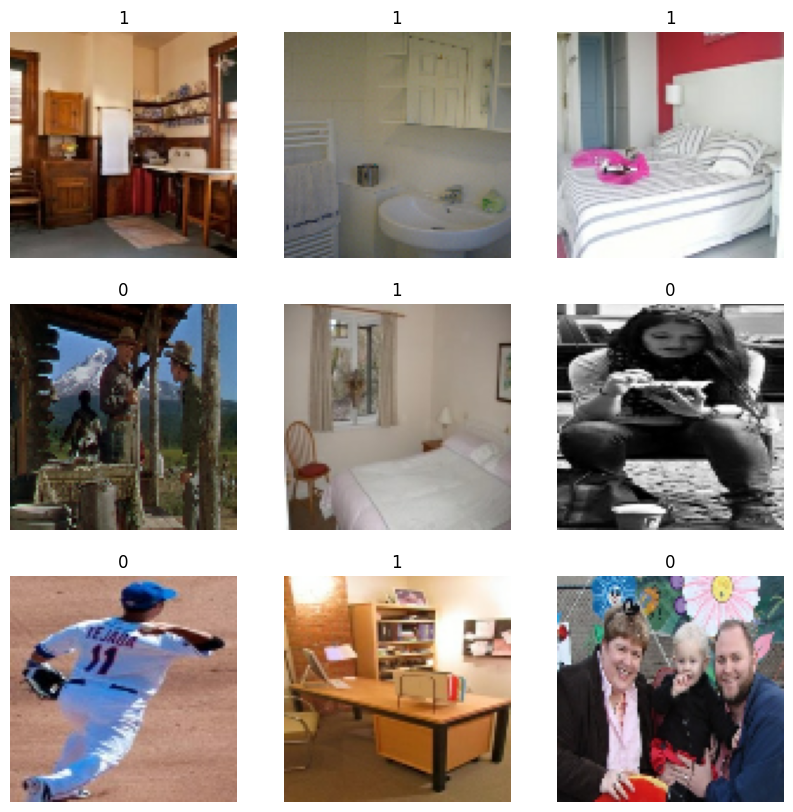

In [5]:
# visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        transposed_image = np.transpose(np.array(images[i]), (1, 2, 0))
        plt.imshow(transposed_image)
        plt.title(int(labels[i]))
        plt.axis("off")


In [6]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomColorDegeneration(factor=0.3, value_range=(0.0, 1.)),
    layers.RandomBrightness(factor=0.05, value_range=(0.0, 1.))
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


In [7]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)


2025-07-09 02:05:27.211693: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


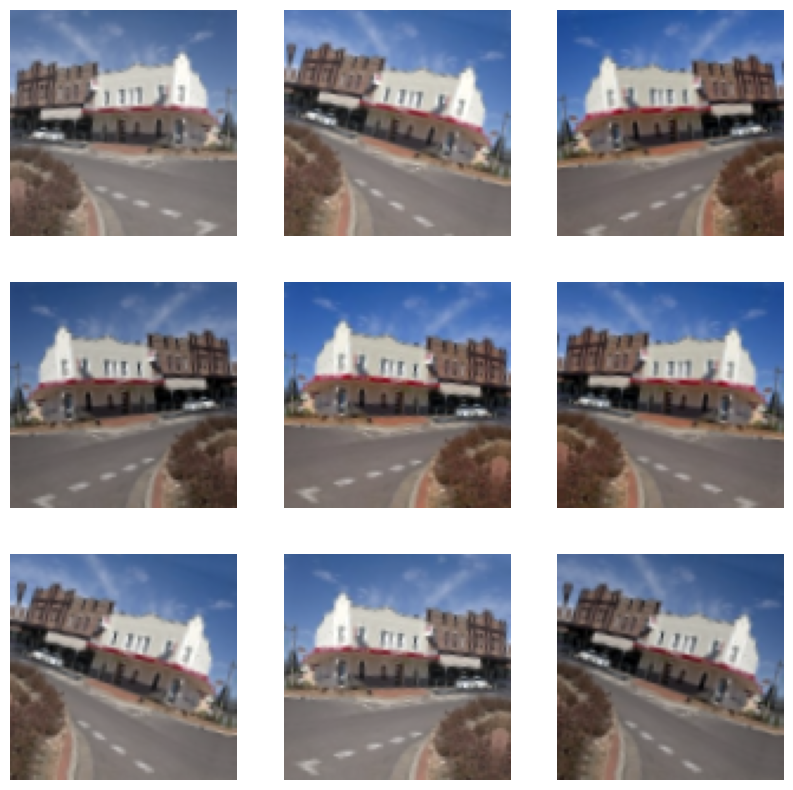

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        transposed_image = np.transpose(np.array(augmented_images[0]), (1, 2, 0))
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(transposed_image)
        plt.axis("off")


In [9]:
@keras.saving.register_keras_serializable()
class FireModule(layers.Layer):
    def __init__(self, squeeze_filters, expand1x1_filters, expand3x3_filters, name=None, **kwargs):
        super(FireModule, self).__init__(name=name, **kwargs)
        self.squeeze_filters = squeeze_filters
        self.expand1x1_filters = expand1x1_filters
        self.expand3x3_filters = expand3x3_filters
        # Define the layers for the Fire module
        self.squeeze = layers.Conv2D(self.squeeze_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand1x1 = layers.Conv2D(self.expand1x1_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand3x3 = layers.Conv2D(self.expand3x3_filters, (3, 3), padding='same', activation='relu', data_format='channels_first')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x1 = self.expand1x1(x)
        x2 = self.expand3x3(x)
        #output = tf.concat([x1, x2], axis=1)  # Concatenate along the channel axis
        output = keras.ops.concatenate([x1, x2], axis=1) # Concatenate along the channel axis
        return output
    
    def get_config(self):
        config = super(FireModule, self).get_config()
        config.update(
            {

            "squeeze_filters": self.squeeze_filters,
            "expand1x1_filters": self.expand1x1_filters,
            "expand3x3_filters":self.expand3x3_filters
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        config['squeeze_filters'] = keras.saving.deserialize_keras_object(config['squeeze_filters'])
        config['expand1x1_filters'] = keras.saving.deserialize_keras_object(config['expand1x1_filters'])
        config['expand3x3_filters'] = keras.saving.deserialize_keras_object(config['expand3x3_filters'])
        return cls(**config)


def create_squeezenet(input_shape=(3, 224, 224), num_classes=2):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    #x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu', data_format='channels_first')(inputs)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), data_format='channels_first')(x)

    # Fire Modules
    x = FireModule(16, 64, 64)(x)
    x = FireModule(16, 64, 64)(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), data_format='channels_first')(x)
    #x = FireModule(32, 128, 128)(x)
    #x = FireModule(32, 128, 128)(x)
    #x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), data_format='channels_first')(x)
    #x = FireModule(48, 192, 192)(x)
    #x = FireModule(48, 192, 192)(x)
    #x = FireModule(64, 256, 256)(x)
    #x = FireModule(64, 256, 256)(x)

    # Classifier
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), activation='relu', data_format='channels_first')(x)
    x = layers.GlobalAveragePooling2D(data_format='channels_first')(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, x)
    return model

# Create the model
model = create_squeezenet(input_shape=(3,96,96))
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 96, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 94, 94)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 46, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fire_module (FireModule)        │ (None, 128, 46, 46)    │        11,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fire_module_1 (FireModule)      │ (None, 128, 46, 46)    │        12,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 22, 22)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 22, 22)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 22, 22)      │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,893 (101.14 KB)

 Trainable params: 25,893 (101.14 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import Callback
epochs=100

class CyclicLR(Callback):
    def __init__(self, base_lr, max_lr, step_size, mode='triangular'):
        super(CyclicLR, self).__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.iteration = 0
        self.history = {}

    def on_train_begin(self, logs=None):
        self.iteration = 0
        self.history['lr'] = []

    def on_batch_end(self, batch, logs=None):
        self.iteration += 1
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        if self.mode == 'triangular':
            lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        else:
            raise ValueError('Mode not supported.')
        
        self.history['lr'].append(lr)
        self.model.optimizer.learning_rate =  lr


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Create a CyclicLR callback
cyclic_lr = CyclicLR(base_lr=1e-4, max_lr=1e-3, step_size=3000)

# Train the model with the CyclicLR callback
model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[cyclic_lr]
)

Epoch 1/100


I0000 00:00:1752019544.090774   25058 service.cc:152] XLA service 0x268f84b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752019544.090877   25058 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-07-09 02:05:44.227810: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752019544.502552   25058 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-09 02:05:44.745006: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.30 = (f32[32,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,96,96]{3,2,1,0} %bitcast.6107, f32[64,3,3,3]{3,2,1,0} %bitcast.5844, f32[64]{0} %bitcast.6531), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBia

  16/1040 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.4655 - loss: 0.6949

I0000 00:00:1752019547.039875   25058 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1037/1040 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5555 - loss: 0.6781

2025-07-09 02:05:58.429711: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.24 = (f32[32,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,96,96]{3,2,1,0} %bitcast.495, f32[64,3,3,3]{3,2,1,0} %bitcast.502, f32[64]{0} %bitcast.504), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-09 02:05:58.589084: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured

1040/1040 ━━━━━━━━━━━━━━━━━━━━ 17s 13ms/step - accuracy: 0.5557 - loss: 0.6780 - val_accuracy: 0.7002 - val_loss: 0.5799
Epoch 2/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6714 - loss: 0.6034 - val_accuracy: 0.6361 - val_loss: 0.6487
Epoch 3/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6961 - loss: 0.5840 - val_accuracy: 0.7224 - val_loss: 0.5538
Epoch 4/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7227 - loss: 0.5525 - val_accuracy: 0.6595 - val_loss: 0.6971
Epoch 5/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7571 - loss: 0.5127 - val_accuracy: 0.7365 - val_loss: 0.5858
Epoch 6/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7733 - loss: 0.4794 - val_accuracy: 0.7119 - val_loss: 0.6395
Epoch 7/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7829 - loss: 0.4660 - val_accuracy: 0.7236 - val_loss: 0.5407
Epoch 8/100
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7758 - los

In [11]:
model.save("minisqueezenet_96.keras")
from keras import layers, models
k_model = keras.models.load_model('minisqueezenet_96.keras',
    custom_objects={"FireModule": FireModule})

/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [12]:
test_ds = keras.utils.image_dataset_from_directory(
    "/home/pico/code/human_presence_classifier/data/human_dataset/test",
    seed=1337,
    image_size=(96,96),
    batch_size=515,
    label_mode="binary"
)

# Reescale image values from 0-255 to 0-1
rescale_fn = layers.Rescaling(1.0 / 255)

test_ds = test_ds.map(lambda x, y: (rescale_fn(x), y))

Found 921 files belonging to 2 classes.


In [13]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

2025-07-09 02:26:30.224158: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.260963: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.267417: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.278237: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.287859: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.293182: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.306688: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.325762: W tensorflow/core/lib/png/png_io.cc:92] PNG warning: iCCP: known incorrect sRGB profile
2025-07-09 02:26:30.343061: W tensorflow/core/lib/png/png_io.cc:92] PNG 

1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6932 - loss: 1.0875

2025-07-09 02:26:32.569768: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.24 = (f32[406,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[406,3,96,96]{3,2,1,0} %bitcast.495, f32[64,3,3,3]{3,2,1,0} %bitcast.502, f32[64]{0} %bitcast.504), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-09 02:26:32.940925: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measur

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7052 - loss: 1.0782
Test Loss: 1.0735564231872559, Test Accuracy: 0.711183488368988


In [10]:
epochs = 60

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    #callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/60


I0000 00:00:1751985537.103470  183488 service.cc:152] XLA service 0x7ec2f4002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751985537.103539  183488 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-07-08 16:38:57.329763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1751985538.353295  183488 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-08 16:38:58.646412: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.30 = (f32[256,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,96,96]{3,2,1,0} %bitcast.6107, f32[64,3,3,3]{3,2,1,0} %bitcast.5844, f32[64]{0} %bitcast.6531), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$c

  3/130 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - acc: 0.4724 - loss: 0.6934

I0000 00:00:1751985542.219439  183488 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - acc: 0.4977 - loss: 0.6923

2025-07-08 16:39:10.609371: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.24 = (f32[256,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[256,3,96,96]{3,2,1,0} %bitcast.495, f32[64,3,3,3]{3,2,1,0} %bitcast.502, f32[64]{0} %bitcast.504), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1/conv2d_1/convolution" source_file="/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-08 16:39:10.895187: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measur

130/130 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - acc: 0.4977 - loss: 0.6923 - val_acc: 0.5276 - val_loss: 0.6893
Epoch 2/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.5013 - loss: 0.6875 - val_acc: 0.5213 - val_loss: 0.6822
Epoch 3/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - acc: 0.5133 - loss: 0.6814 - val_acc: 0.5971 - val_loss: 0.6793
Epoch 4/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.5313 - loss: 0.6759 - val_acc: 0.5880 - val_loss: 0.6695
Epoch 5/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - acc: 0.5443 - loss: 0.6681 - val_acc: 0.5871 - val_loss: 0.6621
Epoch 6/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.5547 - loss: 0.6621 - val_acc: 0.5424 - val_loss: 0.6557
Epoch 7/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.5736 - loss: 0.6585 - val_acc: 0.6160 - val_loss: 0.6485
Epoch 8/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - acc: 0.5844 - loss: 0.6520 - val_acc: 0.6244 - val_loss: 0.6425
Epoch 9/60
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
This image is 100.00% human and 0.00% not human.
[[0.]]


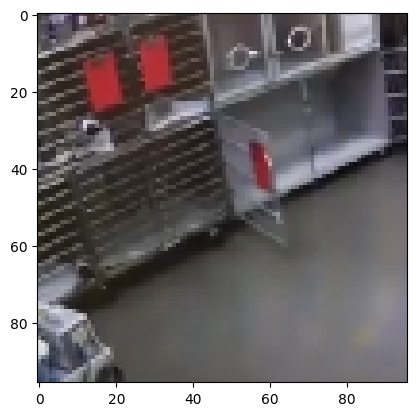

In [27]:
img = keras.utils.load_img("/home/pico/code/human_presence_classifier/data/human_detection_dataset/human detection dataset/0/90.png", target_size=(96, 96))
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(f"This image is {100 * (1 - predictions[0][0]):.2f}% human and {100 * predictions[0][0]:.2f}% not human.")
print(predictions)
